Just do it with keras
---

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')

pi = np.pi

In [3]:
def simulate_trajectory(speed, azi, pitch, target, origin = np.array([0.,0.,0.]), timestep = 0.1, g = -10., distance_only = True):
    #get cartesian velocity from spherical coordinates
    velocity = speed*np.array([
        np.cos(azi)*np.cos(pitch),
        np.sin(azi)*np.cos(pitch),
        np.sin(pitch)
    ])
    acc = np.array([0.,0., g])
    history = [origin, origin+ velocity*timestep + (1/2)*acc*timestep**2]
    position = history[-1]
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    #while the ball is above the ground, timestep to change position
    while position[2] >= 0:
#         print(history[-1])
        position = 2*history[-1] - history[-2] + acc*(timestep**2)
        distances.append(np.linalg.norm(target - position))
        history.append(position)
    if distance_only:
        return np.array(distances).min()
    else:
        return np.array(history)
    
def tf_simulate_trajectory(speed, azi, pitch, target, origin = tf.constant([0.,0.,0.]), timestep = 0.1, g = -10., distance_only = True):
    #get cartesian velocity from spherical coordinates
    velocity = speed*tf.convert_to_tensor([
        tf.math.cos(azi)*tf.math.cos(pitch),
        tf.math.sin(azi)*tf.math.cos(pitch),
        tf.math.sin(pitch)
    ])
    acc = tf.constant([0.,0., g], dtype='float32')
    history = [origin, origin+ velocity*timestep + (1/2)*acc*timestep**2]
    position = history[-1]
    distances = [tf.norm(target - origin), tf.norm(target - position)]
    distances = [tf.norm(target - origin), tf.norm(target - position)]
    #while the ball is above the ground, timestep to change position
    while position[2] >= 0:
#         print(history[-1])
        position = 2*history[-1] - history[-2] + acc*(timestep**2)
        distances.append(tf.norm(target - position))
        history.append(position)
    if distance_only:
        return tf.reduce_min(tf.convert_to_tensor(distances))
    else:
        return tf.convert_to_tensor(history)    
    

In [120]:
tf_simulate_trajectory(100.,pi/23,pi/3,[200,200,100])

<tf.Tensor: shape=(), dtype=float32, numpy=215.75685>

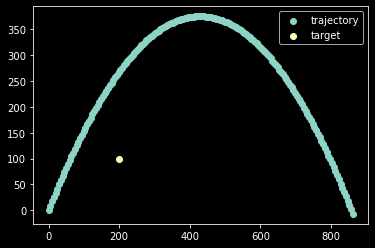

In [54]:
traj = simulate_trajectory(100,pi/23,pi/3,[200,200,100], distance_only = False)
plt.scatter(traj[:,0], traj[:,2], label = 'trajectory')
plt.scatter([200],[100], label = 'target')
plt.legend();

for an actor-critic model, we need a model that estimates the loss given the state and policy output (critic) as well as a model producing the policy (actor).

In [7]:
class actor(keras.Model):
    def __init__(self, units, num_layers, num_outputs, output_activation = None):
        super().__init__()
        self.layer_list = []
        for layer in range(num_layers):
            self.layer_list.append(
                keras.layers.Dense(units = units,
                                  activation = 'relu',
                                  kernel_initializer = keras.initializers.he_normal,
                                  bias_initializer = keras.initializers.he_normal
                                  )
            )
        self.layer_list.append(
            keras.layers.Dense(num_outputs, activation = output_activation)
        )
        
    def call(self, x, training = True):
        x = x[:, tf.newaxis]
        for layer in self.layer_list:
            x = layer(x)
        return tf.squeeze(x, axis = 1)

class cannon:
    def __init__(self, max_speed, azimuth_limit = pi, pitch_limit = pi/2.):
        self.max_speed = max_speed
        self.azimuth_limit = azimuth_limit
        self.pitch_limit = pitch_limit
        
    def load(self, speed_frac, azi_frac, pitch_frac):
        return speed_frac*self.max_speed, azi_frac*self.azimuth_limit, pitch_frac*self.pitch_limit
        

In [8]:
my_Cannon = cannon(250)

In [9]:
#cannon just interprets intensity of inputs into speed and angles
my_Cannon.load(.2, -.3, .5)

(50.0, -0.9424777960769379, 0.7853981633974483)

In [10]:
#actor takes in three values (targetx, targety, targetz) and
#returns three values (speed, azimuth, pitch)
my_Actor = actor(64,2,3, 'sigmoid')

In [11]:
target_test_position = [240,403,2330]
test_policy = my_Actor(tf.constant([target_test_position]))
test_policy

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1., 1., 1.]], dtype=float32)>

In [12]:
#the critic is an actor with six inputs (three for target state,
#three for the actor's output) and 
#returns a single value estimating the closest the projectile gets
#to the target
my_Critic = actor(32,2,1)

In [13]:
test_policy[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>

In [14]:
critic_inputs = np.concatenate([target_test_position,test_policy[0]])
critic_inputs

array([2.40e+02, 4.03e+02, 2.33e+03, 1.00e+00, 1.00e+00, 1.00e+00])

In [15]:
my_Critic(tf.constant([critic_inputs]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-163.80676]], dtype=float32)>

In [16]:
test_speed, test_azi, test_pitch = test_policy[0] + np.array([0.8,pi/6,0.2])
test_speed, test_azi, test_pitch = my_Cannon.load(test_speed, test_azi, test_pitch)
simulate_trajectory(test_speed, test_azi, test_pitch, [12,535,23])

501.9287414550781

the actor wants to minimize the distance to the target
the critic wants to minimize the estimate of the distance

- actor:
    - get target location
    - return policy
    - get min distance of projectile to target as loss
- critic:
    - get target location, actor policy
    - return estimate of distance
    - get difference with real distance as loss
    
The data between training loops will look like:

In [17]:
columns = ['targetx', 'targety', 'targetz', 'speed_policy', 'azi_policy', 'pitch_policy', 'min_distance']

The target positions will always be random.
At the beginning, the speed, azi, and pitch policies will be random. The min_distance will be calculated using simulate_trajectory() of these.

The critic will be trained on this data. It is essentially an estimator of simulate_trajectory().
The actor will feed answers to the critic, and get the critic's responses as losses. This will involve a custom training loop.

In [18]:
def simulate_row(row, max_speed = 250, distance_only = True):
    sp = max_speed * row['speed_policy']
    az = np.pi * row['azi_policy']
    pitch = np.pi * row['pitch_policy']
    target = row[['xtarget', 'ytarget','ztarget']]
    return simulate_trajectory(sp, az, pitch, target, distance_only = distance_only)

In [19]:
#define columns
columns = ['xtarget', 'ytarget', 'ztarget', 'speed_policy', 'azi_policy', 'pitch_policy', 'min_distance']

#make dataframe
df = pd.DataFrame([], columns = columns)

#make rng for target position
seed = 2022
rng = np.random.default_rng(seed)

random_data_length = 1000
#create random targets (1 cm resolution)
df['xtarget'] = np.around(2000*rng.uniform(-1,1,random_data_length),2)
df['ytarget'] = np.around(2000*rng.uniform(-1,1,random_data_length),2)
df['ztarget'] = np.around(2000*rng.uniform(0,1,random_data_length),2)

#create random policies
df['speed_policy'] = rng.uniform(0,1,random_data_length)
df['azi_policy'] = rng.uniform(-1,1,random_data_length)
df['pitch_policy'] = rng.uniform(0,1,random_data_length)

#calculate distance with each policy
df['min_distance'] = df.apply(lambda entry: np.around(simulate_row(entry),2) , axis = 1)

In [20]:
df

,xtarget,ytarget,ztarget,speed_policy,azi_policy,pitch_policy,min_distance
0,-1010.30,440.97,423.67,0.693005,-0.787709,0.261815,971.99
1,-1628.04,1581.98,334.69,0.488692,-0.703201,0.751850,2251.72
2,447.05,1593.62,1357.60,0.558932,0.799164,0.198552,1872.76
3,-1757.35,-1822.98,7.91,0.574227,0.105213,0.738062,1170.19
4,644.13,1929.06,35.80,0.027184,0.540124,0.004422,2033.46
...,...,...,...,...,...,...,...
995,-1207.65,-169.48,167.40,0.260878,-0.031868,0.037650,1230.92
996,-999.92,-1575.44,1948.73,0.743194,0.820957,0.479307,1891.95
997,328.13,-1151.63,1452.09,0.335817,-0.724218,0.327324,1588.79
998,-1370.34,516.24,824.78,0.887975,-0.608419,0.511137,1464.07


In [22]:
# get first critic preds and losses

my_Critic = actor(32,2,1)
my_Actor = actor(32,2,1)

x = df.drop(columns=['min_distance'])
y = df['min_distance']



num_epochs = 250
epoch_update_period = 50
loss_fn = tf.losses.mean_absolute_error
optimizer = tf.optimizers.Adam(learning_rate=0.01)

losses = []


for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        preds = my_Critic.call(x.to_numpy())
        loss = tf.reduce_mean(loss_fn(preds,y))
        grads = tape.gradient(loss, my_Critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, my_Critic.trainable_variables));
    losses.append(loss)
    if epoch%epoch_update_period == 0:
        print(f'Epoch {epoch}: loss {loss}')



Epoch 0: loss 2783.3013725747746
Epoch 50: loss 634.0671854562036
Epoch 100: loss 618.1427056495447
Epoch 150: loss 614.4337362528858
Epoch 200: loss 612.6924790507958


Text(0, 0.5, 'distance (m)')

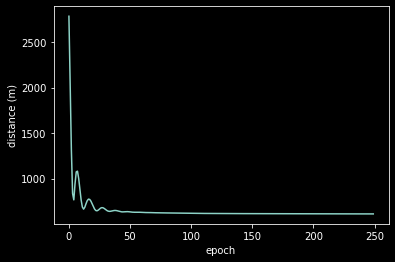

In [23]:
plt.plot(losses, label = 'loss')
plt.xlabel('epoch')
plt.ylabel('distance (m)')

In [71]:
np.sqrt(np.mean((tf.reshape(preds,(1000)) - y)**2))

454.95612

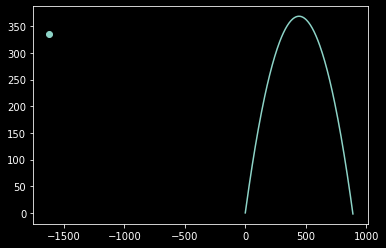

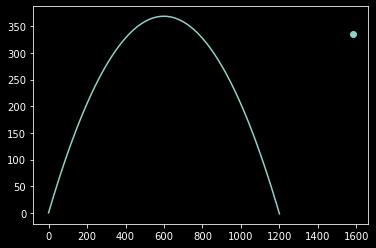

tf.Tensor([[1730.2112]], shape=(1, 1), dtype=float32) 2251.7166532002407


In [72]:
row_to_test = 1
test_sim = simulate_row(df.loc[row_to_test], distance_only=False)
plt.plot(test_sim[:,0], test_sim[:,2])
plt.scatter([df.loc[row_to_test]['xtarget']], [df.loc[row_to_test]['ztarget']])
plt.show()
plt.plot(test_sim[:,1], test_sim[:,2])
plt.scatter([df.loc[row_to_test]['ytarget']], [df.loc[row_to_test]['ztarget']])
plt.show()
print(
    my_Critic(df.drop(columns = ['min_distance']).loc[row_to_test].to_numpy().reshape((1,6))),
    simulate_row(df.loc[row_to_test], distance_only=True)
)

# Training Loop